In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from numpy import random
import pickle
import scipy.stats as st
import itertools 
import seaborn as sns

# Filters dataframe based on neuron type. 
# Establishes a synapse threshold of greater than 1
# data - the dataframe
# col_substr - regex to select for substrings that represent neuron type in columns
# row_substr - regex to select for substrings that represent neuron type in rows
# row_header - header for indices
def filter_neuron_types(data, col_substr, row_substr, idx_header):
    first_column = df.iloc[:, 0] # gets first column to use as row indices
    # columns
    new_df = data.filter(regex=col_substr, axis='columns') 
    
    # rows
    new_df.insert(0, idx_header, first_column, True) # inserts column with row labels into the new dataframe
    new_df.set_index(idx_header, inplace=True) # sets inserted column as dataframe indicies
    new_df = new_df.filter(regex=row_substr, axis='index')
    
    # establishing a threshold of num synapses > 1 to count as a connection
    num_rows = len(new_df)
    # loops thru rows of new_df
    for i in range(num_rows):
        row = new_df.iloc[i] # gets row
        new_row = np.where(row == 1, 0, row) # if synaspse num = 1, change to 0
        new_df.iloc[i] = new_row
    
    return new_df

# Normalizes weights by column's sum in a pandas df
# df - dataframe
# sum_of_w - the sum of the weights
def normalize_weights_df(df, sum_of_w):
    col = len(df.columns)
    #df.iloc[:,0:col] = df.iloc[:,0:col].apply(lambda x: x / np.linalg.norm(x), axis=0)
    #df = normalize(df, axis=0, norm='l1') # normalize by column to sum of 1
    for c in range(col):
        w = df.iloc[:,c]
        s = sum(abs(w)) # sum of column
        if (s != 0):
            df.iloc[:,c] = [i/s for i in w]
    return sum_of_w * df

# Normalizes weights by column's sum in a numpy array
# arr - numpy array
# sum_of_w - the sum of the weights
def normalize_weights_np(arr, sum_of_w):
    col = len(arr[0])
    #df.iloc[:,0:col] = df.iloc[:,0:col].apply(lambda x: x / np.linalg.norm(x), axis=0)
    #df = normalize(df, axis=0, norm='l1') # normalize by column to sum of 1
    for c in range(col):
        w = arr[:,c]
        s = sum(abs(w)) # sum of column
        if (s != 0):
            arr[:,c] = [i/s for i in w]
    return sum_of_w * arr


df = pd.read_csv('connectivity matrix table 1.csv') # matrix of connections between neurons

# FILTER DATA FOR PNs (rows) to KCs (columns) CONNECTIONS -> pn_kc
pn_kc = filter_neuron_types(df, "(?=.*KC)(?=.*left)", "(?=.*PN)(?=.*left)", "Presynaptic PNs") # filter w/ regex PNs and KCs

# normalize weights
pn_kc = normalize_weights_df(pn_kc, 1)
#pn_kc = pn_kc.fillna(0)

# FILTER DATA FOR KCs TO MBONs CONNECTIONS -> kc_to_mbon
kc_mbon = filter_neuron_types(df, "(?=.*MBON)(?=.*left)", "(?=.*KC)(?=.*left)", "Presynaptic KCs") # filter w/ regex for KCs and MBON lefts

# take out MBONs with no KC connections
kc_mbon = kc_mbon.drop(kc_mbon.loc[:, (kc_mbon.sum(axis=0) == 0)], axis=1)

# adding a fictional MBON
fict_weights = np.full(len(kc_mbon), 0.1) # initializing all weights at 0.1
kc_mbon['MBON-fict'] = fict_weights

# normalizing weights
kc_mbon = normalize_weights_df(kc_mbon, 1)
kc_mbon = kc_mbon.fillna(0)

# Set numbers
num_kcs = len(pn_kc.columns)
num_pns = len(pn_kc) # number of PNs (40), also = number of dimensions of the odor
num_mbons = len(kc_mbon.columns)
R = 10 # number of realizations of training


# Figure 1

[[1 0 1 1 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 1 1 0 1 0 1 1 0 0 1 0 0 1 0 1 1
  1 1 0 1]
 [0 1 0 0 0 1 0 0 1 0 0 1 1 1 1 0 1 1 1 0 1 0 1 1 1 0 1 1 0 1 1 1 0 1 0 0
  1 0 1 0]
 [1 1 1 1 0 0 1 1 0 0 0 1 0 1 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 1 1 1 1 1 1 0
  1 1 1 1]
 [0 1 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0
  0 1 0 0]
 [0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 1 0 1 1 1
  0 1 0 1]
 [0 1 1 1 0 1 1 0 1 0 1 0 1 1 0 1 1 0 0 0 0 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1
  1 0 0 1]
 [0 0 0 0 0 1 0 0 0 1 1 1 1 1 0 1 0 0 1 0 1 0 0 0 1 0 0 1 1 1 0 1 0 0 0 0
  0 0 0 1]
 [0 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0
  1 1 0 0]
 [0 0 1 0 0 0 1 1 0 0 1 0 0 0 1 1 1 1 1 1 0 0 1 1 0 0 0 0 1 1 0 1 1 0 1 0
  1 0 1 1]
 [0 1 1 1 1 1 0 0 0 1 1 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 1 1 1 0 1 0 0 1 1 0
  0 1 0 1]]


Text(0, 0.5, 'Projection Neuron 2')

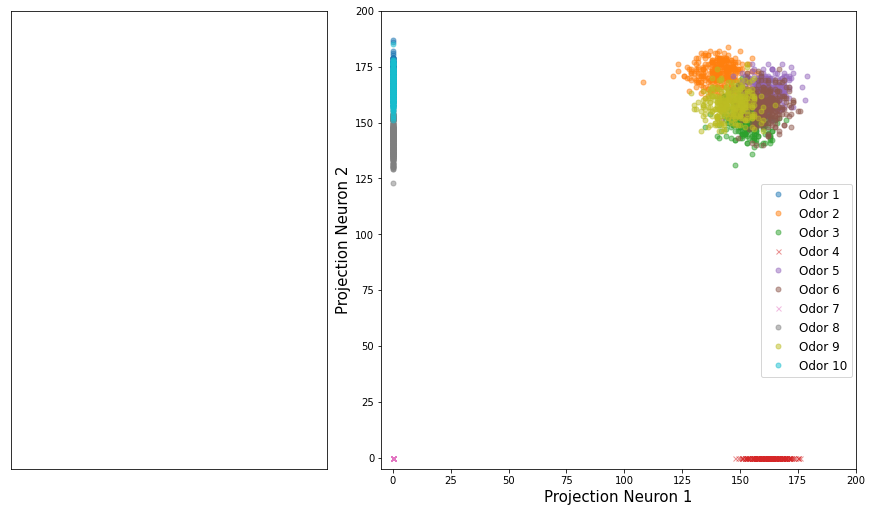

In [2]:
fig = plt.figure(figsize=(12,7), constrained_layout=True)
gs = fig.add_gridspec(1, 5, wspace=5)


# 1A MODEL APPROXIMATION
f_ax1 = fig.add_subplot(gs[:, 0:2])
# f_ax1.set_title('Model Approximation', fontsize=20)

# remove x and y ticks
# x axis
f_ax1.set_xticklabels([])
f_ax1.set_xticks([])

# y axis
f_ax1.set_yticklabels([])
f_ax1.set_yticks([])


# 1B DISTRIBUTION OF PN ACTIVITY
f_ax2 = fig.add_subplot(gs[:, 2:5])

N = 10
num_pns = 40
num_inputs = 50000
spikes = 200

with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/10-odors/control/input-means4.pkl', 'rb') as f:
    input_means = pickle.load(f)
    
response = input_means

bool_response = np.where(input_means > 0, 1, 0) # boolean version of response (1=fire, 0=no fire)
print(bool_response)

all_inputs = np.zeros((num_inputs, num_pns))
odor_idx = num_inputs//N
pn_inputs = np.zeros((N, num_inputs//N, num_pns))
for n in range(N):
    inputs = np.random.binomial(spikes, response[n], size=(num_inputs//N, num_pns))
    all_inputs[n*odor_idx:odor_idx*(n + 1)] = inputs
    pn_inputs[n] = inputs

# categories = ['x', 'o', 'o'] # for 3 odors
categories = ['o', 'o', 'o', 'x', 'o', 'o', 'x', 'o', 'o', 'o'] # firing pattern for 10 odors
labels = []
for i in range(N):
    labels.append("Odor {}".format(i+1))

# plotting
for i in range(N):
    # 22, 23 - 10 odors
    # 9, 10 - 3 odors
    f_ax2.plot(pn_inputs[i, 0:300, 22], pn_inputs[i, 0:300, 23], marker = categories[i], markersize=5, alpha = 0.5,
             label = labels[i], linestyle = '')
#     sns.scatterplot(x = pn_inputs[i, :, 9], y = pn_inputs[i, :, 10], s = 100, palette = 'Accent', style = categories[i])
f_ax2.set_xlim(-5, 200)
f_ax2.set_ylim(-5, 200)
f_ax2.legend(loc=(0.8,0.2), prop={'size': 12})
# f_ax2.set_title('PN Activity in Response to {} Odors'.format(N), fontsize=20)
f_ax2.set_xlabel('Projection Neuron 1', fontsize=15)
f_ax2.set_ylabel('Projection Neuron 2', fontsize=15)


# Figure 2

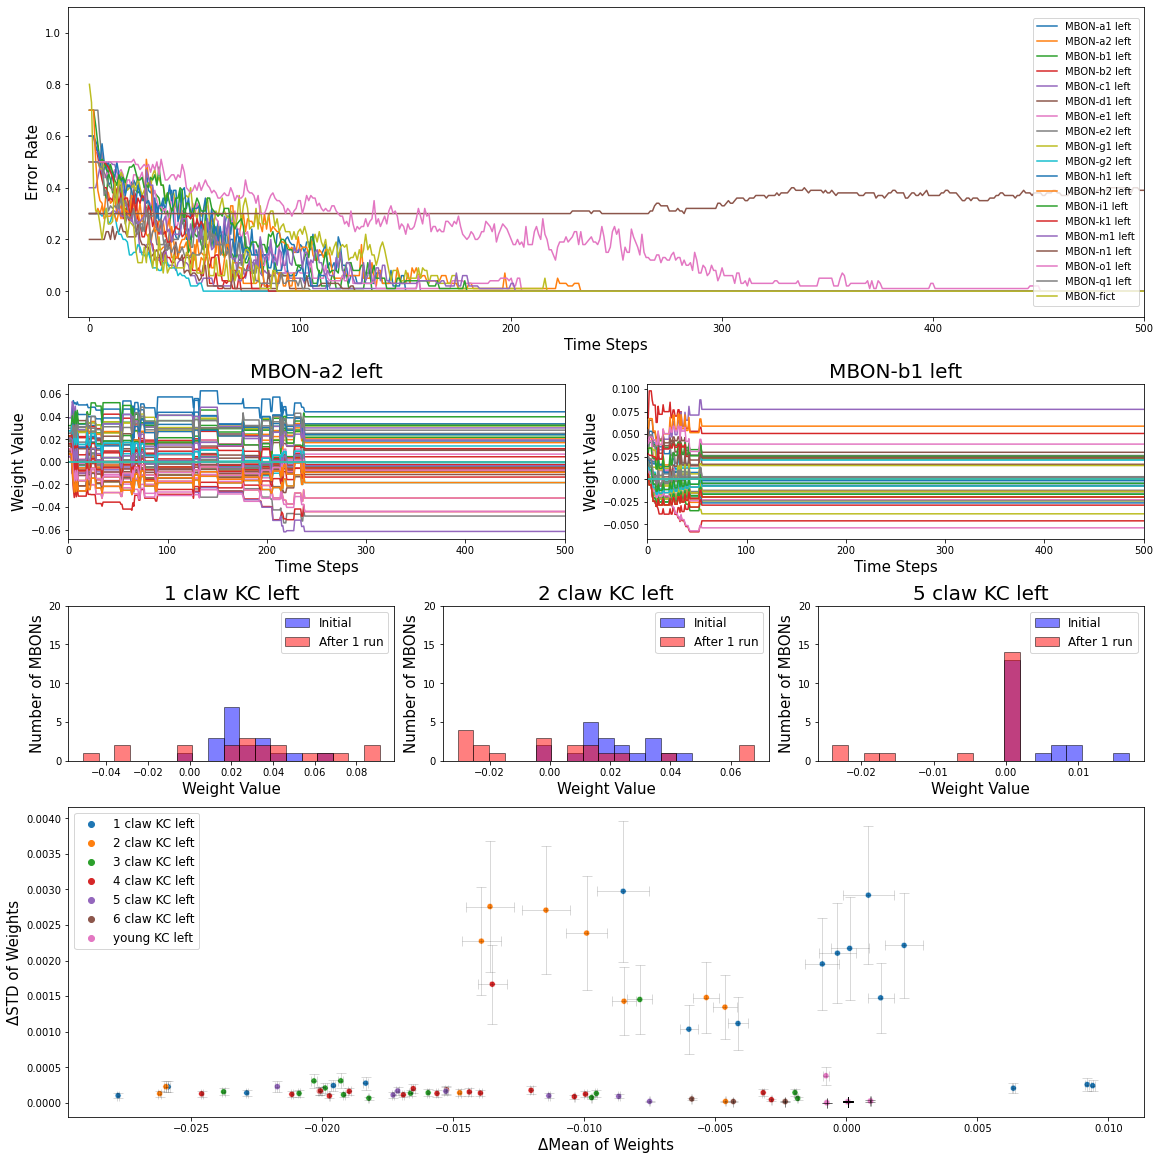

In [8]:
axis_fontsize = 15
title_fontsize = 20
fig2 = plt.figure(figsize=(16,16), constrained_layout=True)
gs2 = fig2.add_gridspec(ncols=6, nrows=6)

# 2A AVERAGE ERROR OVER TIME
f2_ax1 = fig2.add_subplot(gs2[0:2, :])

with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/10-odors/control/all-error-rates4.pkl', 'rb') as f:
    error_rate_over_time = pickle.load(f)

avg_error = np.mean(error_rate_over_time, axis=0)

x = np.linspace(0, 5000, 5000)
for i in range(num_mbons):
    f2_ax1.plot(x, avg_error[:,i], label = kc_mbon.columns[i])
    
f2_ax1.legend(fontsize=10, loc=7)
f2_ax1.set_ylim(-0.1, 1.1)
f2_ax1.set_xlim(-10, 500)
# f2_ax1.set_title("Avg Error Rate over Time for 19 MBONs", fontsize=title_fontsize)
f2_ax1.set_xlabel("Time Steps", fontsize=axis_fontsize)
f2_ax1.set_ylabel("Error Rate", fontsize=axis_fontsize)

# 2B WEIGHTS OVER TIME ACROSS KCS FOR MBON-a2 left
f2_ax2 = fig2.add_subplot(gs2[2, 0:3])

with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/10-odors/control2/total-weights7.pkl', 'rb') as f:
    weights_over_time = pickle.load(f)
    
x = np.linspace(0, 5000, 5000)

for k in range(num_kcs):
    f2_ax2.plot(x, weights_over_time[0, :, k, 1]) # plot weights over time for MBON-a2 left (index=1)
f2_ax2.set_title("{}".format(kc_mbon.columns[1]), fontsize=title_fontsize)
f2_ax2.set_xlim(0, 500)
f2_ax2.set_xlabel("Time Steps", fontsize=axis_fontsize)
f2_ax2.set_ylabel("Weight Value", fontsize=axis_fontsize)

# 2C WEIGHTS OVER TIME ACROSS KCS FOR MBON-b1 left
f2_ax3 = fig2.add_subplot(gs2[2, 3:])

x = np.linspace(0, 5000, 5000)

for k in range(num_kcs):
    f2_ax3.plot(x, weights_over_time[0, :, k, 2]) # plot weights over time for MBON-b1 left (index=2)
f2_ax3.set_title("{}".format(kc_mbon.columns[2]), fontsize=title_fontsize)
f2_ax3.set_xlim(0, 500)
f2_ax3.set_xlabel("Time Steps", fontsize=axis_fontsize)
f2_ax3.set_ylabel("Weight Value", fontsize=axis_fontsize)

# 2D 1 claw KC left (index=2) WEIGHT DISTRIBUTION
f2_ax4 = fig2.add_subplot(gs2[3, 0:2])

with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/3-odors/control2/total-weights7.pkl', 'rb') as f:
    weights_over_time = pickle.load(f)
    
# average final weights over 10
avg_weights = np.mean(weights_over_time, axis=0)

x = np.zeros((3, num_mbons))
x[0] = kc_mbon.iloc[2]
x[1] = weights_over_time[0, -1, 2] # final weights after realization #1 of training
x[2] = avg_weights[-1, 2]

# initial weights
f2_ax4.hist(x[0], bins=np.linspace(x.min(), x.max(), 20), edgecolor='black', color='blue', alpha=0.5, label='Initial')

# final weights after 1 training run
f2_ax4.hist(x[1], bins=np.linspace(x.min(), x.max(), 20), edgecolor='black', color='red', alpha=0.5, label='After 1 run')

# final weights avgeraged over 10 training runs
#             axis[i, j].hist(x[2], bins=np.linspace(x.min(), x.max(), 20), edgecolor='black', color='green', alpha=0.5, label='avg over 10')

f2_ax4.set_title(kc_mbon.index[2], fontsize=title_fontsize)
f2_ax4.set_xlabel('Weight Value', fontsize=axis_fontsize)
f2_ax4.set_ylabel('Number of MBONs', fontsize=axis_fontsize)
f2_ax4.set_ylim(0, 20)
f2_ax4.legend(fontsize=12)

# 2E 2 claw KC left (index=18) WEIGHT DISTRIBUTION
f2_ax5 = fig2.add_subplot(gs2[3, 2:4])

x = np.zeros((3, num_mbons))
x[0] = kc_mbon.iloc[18]
x[1] = weights_over_time[0, -1, 18] # final weights after realization #1 of training
x[2] = avg_weights[-1, 18]

# initial weights
f2_ax5.hist(x[0], bins=np.linspace(x.min(), x.max(), 20), edgecolor='black', color='blue', alpha=0.5, label='Initial')

# final weights after 1 training run
f2_ax5.hist(x[1], bins=np.linspace(x.min(), x.max(), 20), edgecolor='black', color='red', alpha=0.5, label='After 1 run')

# final weights avgeraged over 10 training runs
#             axis[i, j].hist(x[2], bins=np.linspace(x.min(), x.max(), 20), edgecolor='black', color='green', alpha=0.5, label='avg over 10')

f2_ax5.set_title(kc_mbon.index[18], fontsize=title_fontsize)
f2_ax5.set_xlabel('Weight Value', fontsize=axis_fontsize)
f2_ax5.set_ylabel('Number of MBONs', fontsize=axis_fontsize)
f2_ax5.set_ylim(0, 20)
f2_ax5.legend(fontsize=12)

# 2F 5 claw KC left (index=67) WEIGHT DISTRIBUTION
f2_ax6 = fig2.add_subplot(gs2[3, 4:])

x = np.zeros((3, num_mbons))
x[0] = kc_mbon.iloc[61]
x[1] = weights_over_time[0, -1, 61] # final weights after realization #1 of training
x[2] = avg_weights[-1, 61]

# initial weights
f2_ax6.hist(x[0], bins=np.linspace(x.min(), x.max(), 20), edgecolor='black', color='blue', alpha=0.5, label='Initial')

# final weights after 1 training run
f2_ax6.hist(x[1], bins=np.linspace(x.min(), x.max(), 20), edgecolor='black', color='red', alpha=0.5, label='After 1 run')

# final weights avgeraged over 10 training runs
#             axis[i, j].hist(x[2], bins=np.linspace(x.min(), x.max(), 20), edgecolor='black', color='green', alpha=0.5, label='avg over 10')

f2_ax6.set_title(kc_mbon.index[67], fontsize=title_fontsize)
f2_ax6.set_xlabel('Weight Value', fontsize=axis_fontsize)
f2_ax6.set_ylabel('Number of MBONs', fontsize=axis_fontsize)
f2_ax6.set_ylim(0, 20)
f2_ax6.legend(fontsize=12)

# 2G SCATTER PLOT OF DELTA MEAN & STD OF WEIGHTS
f2_ax7 = fig2.add_subplot(gs2[4:, :])

mean_weights = np.mean(weights_over_time, axis = 3)
std_weights = np.mean(weights_over_time, axis = 3)

# organize into dataframe 
# x axis - difference in means of final and initial KC weights
x = mean_weights[:, -1] - mean_weights[:, 0]

# y axis - difference in stds of final and initial KC weights
y = std_weights[:, -1] - std_weights[:, 0]

# average mean and std across realizations
avg_of_mean_weights = np.mean(x, axis = 0)
avg_of_std_weights = np.std(y, axis = 0)

# create dataframe to organize scatter plot values
names = kc_mbon.index
# print(names.shape)
df = pd.DataFrame({'Type of KC':names, 'Mean':avg_of_mean_weights, 'STD':avg_of_std_weights})

colors = {'1 claw KC left':'blue', '2 claw KC left':'orange', '3 claw KC left':'green', '4 claw KC left':'red',
          '5 claw KC left':'purple', '6 claw KC left':'brown', 'young KC left':'pink'}

# get sem
sem_m = st.sem(x, axis=0)
sem_s = st.sem(y, axis=0)

# plot scatter plots of std vs mean
f2_ax7.errorbar(x=df['Mean'], y=df['STD'], xerr=sem_m, yerr=sem_s, capsize=5, color='black', alpha=0.15,
                linewidth=1, linestyle='', marker=None)
sns.scatterplot(ax=f2_ax7, x=df['Mean'], y=df['STD'], hue=df['Type of KC'])

# sns.pointplot(x=df['Mean'], y=df['STD'], hue=df['Type of KC'], data=df, join=False)
f2_ax7.set_xlabel('ΔMean of Weights', fontsize=axis_fontsize)
f2_ax7.set_ylabel('ΔSTD of Weights', fontsize=axis_fontsize)
f2_ax7.legend(loc=2, fontsize=12)
# f2_ax7.set_title('Average ΔSTD of Weights vs. ΔMean of Weights', fontsize=title_fontsize)


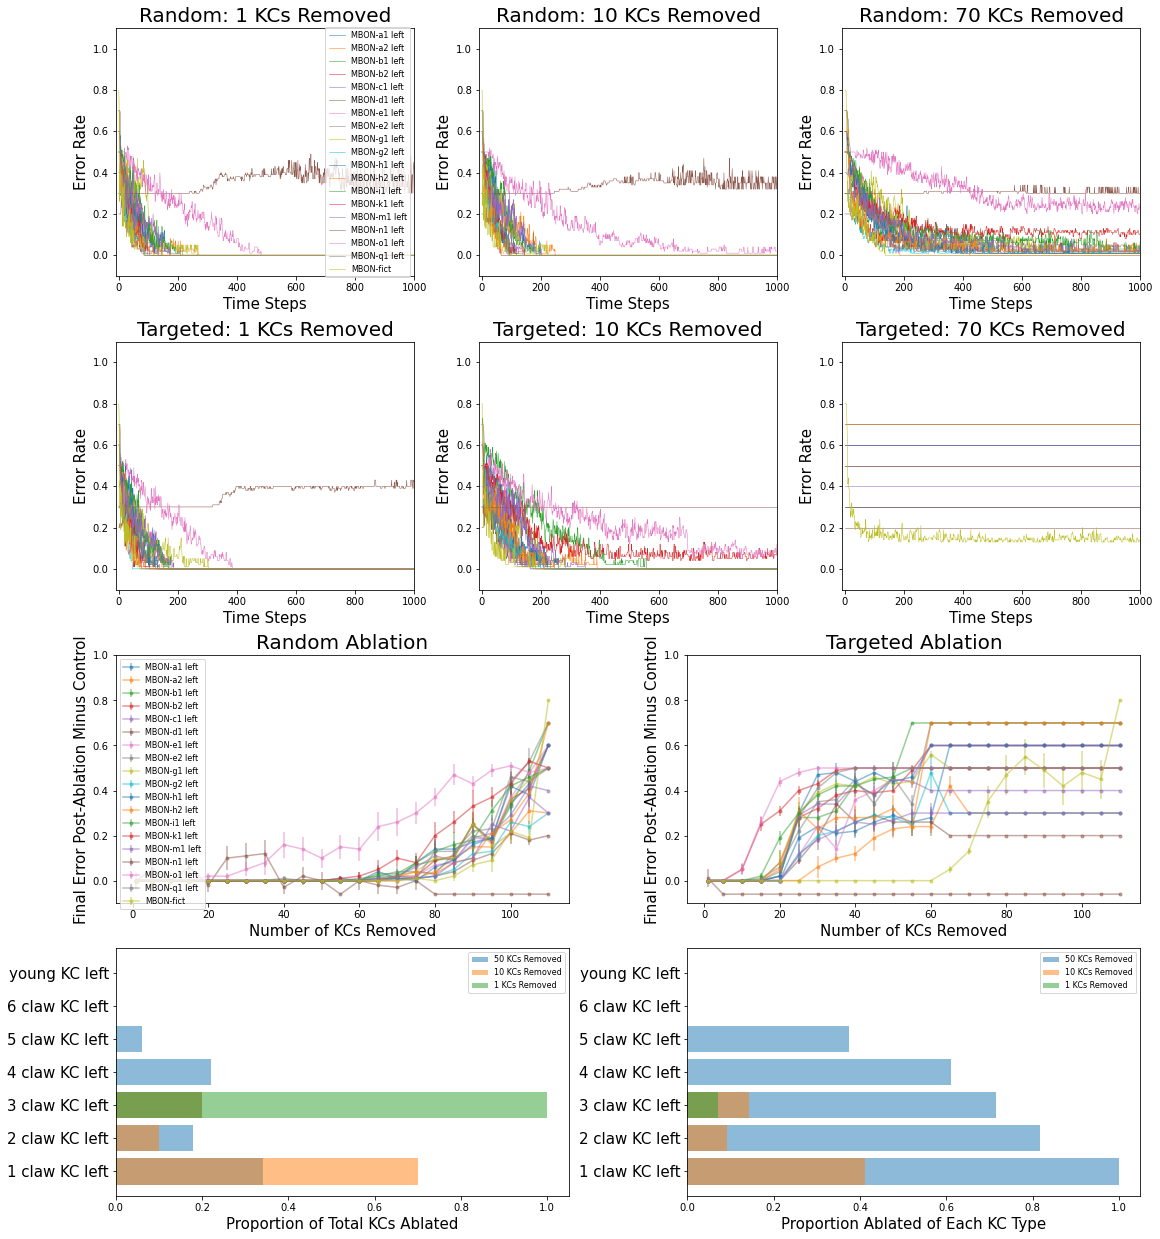

In [10]:
axis_fontsize = 15
title_fontsize = 20
legend_fontsize = 8
fig3 = plt.figure(figsize=(16,30), constrained_layout=True)
gs3 = fig3.add_gridspec(ncols=6, nrows=15)

# 3C ERROR OVER TIME (REMOVED 1) - RANDOM
f3_ax3 = fig3.add_subplot(gs3[6:8, 0:2])

# list of num of KCs removed
num_removed = np.ones(23)
num_removed[1:] = np.linspace(5, 110, 22)
num_removed = num_removed.astype(int)

with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/10-odors/random-ablation/all-error-rates6.pkl', 'rb') as f:
    error_rate_over_time = pickle.load(f)

avg_error = np.mean(error_rate_over_time, axis=1)

x = np.linspace(0, 5000, 5000)

for i in range(num_mbons):
    f3_ax3.plot(x, avg_error[0, : ,i], label = kc_mbon.columns[i], linewidth = 0.5)
    
f3_ax3.set_ylim(-0.1, 1.1)
f3_ax3.set_xlim(-10, 1000)
f3_ax3.legend(fontsize=legend_fontsize, loc=7)
f3_ax3.set_title("Random: {} KCs Removed".format(num_removed[0]), fontsize=title_fontsize)
f3_ax3.set_xlabel("Time Steps", fontsize=axis_fontsize)
f3_ax3.set_ylabel("Error Rate", fontsize=axis_fontsize)

# 3D ERROR OVER TIME (REMOVED 10) - RANDOM
f3_ax4 = fig3.add_subplot(gs3[6:8, 2:4])

for i in range(num_mbons):
    f3_ax4.plot(x, avg_error[2, :, i], label = kc_mbon.columns[i], linewidth = 0.5)
    
f3_ax4.set_ylim(-0.1, 1.1)
f3_ax4.set_xlim(-10, 1000)
# f3_ax4.legend(fontsize=legend_fontsize, loc=7)
f3_ax4.set_title("Random: {} KCs Removed".format(num_removed[2]), fontsize=title_fontsize)
f3_ax4.set_xlabel("Time Steps", fontsize=axis_fontsize)
f3_ax4.set_ylabel("Error Rate", fontsize=axis_fontsize)

# 3E ERROR OVER TIME (REMOVED 70) - RANDOM
f3_ax5 = fig3.add_subplot(gs3[6:8, 4:])

for i in range(num_mbons):
    f3_ax5.plot(x, avg_error[14, :, i], label = kc_mbon.columns[i], linewidth = 0.5)
    
f3_ax5.set_ylim(-0.1, 1.1)
f3_ax5.set_xlim(-10, 1000)
# f3_ax5.legend(fontsize=legend_fontsize, loc=7)
f3_ax5.set_title("Random: {} KCs Removed".format(num_removed[14]), fontsize=title_fontsize)
f3_ax5.set_xlabel("Time Steps", fontsize=axis_fontsize)
f3_ax5.set_ylabel("Error Rate", fontsize=axis_fontsize)

# 3F ERROR OVER TIME (REMOVED 1) - TARGETED
f3_ax6 = fig3.add_subplot(gs3[8:10, 0:2])

with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/10-odors/targeted-ablation/all-error-rates5.pkl', 'rb') as f:
    error_rate_over_time = pickle.load(f)

avg_error = np.mean(error_rate_over_time, axis=1)

x = np.linspace(0, 5000, 5000)

for i in range(num_mbons):
    f3_ax6.plot(x, avg_error[0, : ,i], label = kc_mbon.columns[i], linewidth = 0.5)
    
f3_ax6.set_ylim(-0.1, 1.1)
f3_ax6.set_xlim(-10, 1000)
# f3_ax6.legend(fontsize=legend_fontsize, loc=7)
f3_ax6.set_title("Targeted: {} KCs Removed".format(num_removed[0]), fontsize=title_fontsize)
f3_ax6.set_xlabel("Time Steps", fontsize=axis_fontsize)
f3_ax6.set_ylabel("Error Rate", fontsize=axis_fontsize)

# 3G ERROR OVER TIME (REMOVED 10) - TARGETED
f3_ax7 = fig3.add_subplot(gs3[8:10, 2:4])

for i in range(num_mbons):
    f3_ax7.plot(x, avg_error[2, :, i], label = kc_mbon.columns[i], linewidth = 0.5)
    
f3_ax7.set_ylim(-0.1, 1.1)
f3_ax7.set_xlim(-10, 1000)
# f3_ax7.legend(fontsize=legend_fontsize, loc=7)
f3_ax7.set_title("Targeted: {} KCs Removed".format(num_removed[2]), fontsize=title_fontsize)
f3_ax7.set_xlabel("Time Steps", fontsize=axis_fontsize)
f3_ax7.set_ylabel("Error Rate", fontsize=axis_fontsize)

# 3H ERROR OVER TIME (REMOVED 70) - TARGETED
f3_ax8 = fig3.add_subplot(gs3[8:10, 4:])

for i in range(num_mbons):
    f3_ax8.plot(x, avg_error[14, :, i], label = kc_mbon.columns[i], linewidth = 0.5)
    
f3_ax8.set_ylim(-0.1, 1.1)
f3_ax8.set_xlim(-10, 1000)
# f3_ax8.legend(fontsize=legend_fontsize, loc=7)
f3_ax8.set_title("Targeted: {} KCs Removed".format(num_removed[14]), fontsize=title_fontsize)
f3_ax8.set_xlabel("Time Steps", fontsize=axis_fontsize)
f3_ax8.set_ylabel("Error Rate", fontsize=axis_fontsize)

# 3I ERROR VS NUM KCS ABLATED - RANDOM
f3_ax9 = fig3.add_subplot(gs3[10:12, 0:3])

num_mbons = 19
K = 23
T = 5000

# import data
with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/10-odors/random-ablation/all-error-rates6.pkl', 'rb') as f:
    error_over_time = pickle.load(f) # dimensions: K, R, T, num_mbons
    
with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v2/10-odors/control/all-error-rates4.pkl', 'rb') as f:
    error_control = pickle.load(f) # dimensions: R, T, num_mbons

# x-axis -> number of KCs removed
numbers = np.ones(23)
numbers[1:] = np.linspace(5, 110, 22)
numbers = numbers.astype(int).tolist() 
x = []       
for i in range(num_mbons):
    for j in range(K):
        x.append(numbers[j])

# y-axis - avg final error rate
avg_error0 = np.mean(error_control, axis=0)
avg_error = np.zeros((K, T, num_mbons))
for i in range(K):
    avg_error[i] = np.mean(error_over_time[i], axis=0)

std_y = np.zeros((K, T, num_mbons))
for i in range(K):
#     std_y[i] = np.std(error_over_time[i], axis=0)
    std_y[i] = st.sem(error_over_time[i], axis=0)

yerr = []
for k in range(num_mbons):
    for i in range(K):
        yerr.append(std_y[i,-1,k])
    
y = []
# add differences in ablation error rate and control
for k in range(num_mbons):
    for i in range(K):
        y.append(avg_error[i,-1,k] - avg_error0[-1,k])

# plot points with lines and labels
names = kc_mbon.columns
for p in range(num_mbons):
    start = p * K
    end = (p * K) + K
#     plt.scatter(x[start:end], y[start:end], alpha=0.3)
#     plt.plot(x[start:end], y[start:end], label=kc_mbon.columns[p], alpha=0.8)
    f3_ax9.errorbar(x[start:end], y[start:end], yerr=yerr[start:end], fmt="o", ls='solid', alpha = 0.5, 
                    label=kc_mbon.columns[p], ms=3)
#     plt.text(110, y[end-1], names[p], fontdict=dict(color='black', alpha=0.8, size=10, fontfamily='sans-serif'))

f3_ax9.set_xlabel("Number of KCs Removed", fontsize=axis_fontsize)
f3_ax9.set_ylabel("Final Error Post-Ablation Minus Control", fontsize=axis_fontsize)
# plt.xticks(numbers, fontsize=18)
# plt.yticks(fontsize=18)
f3_ax9.set_ylim(-0.1, 1.0)
f3_ax9.set_title("Random Ablation", fontsize=title_fontsize)
f3_ax9.legend(fontsize=legend_fontsize, loc=2)

# 3J ERROR VS NUM KCS ABLATED - TARGETED
f3_ax10 = fig3.add_subplot(gs3[10:12, 3:])

# import data
with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/10-odors/targeted-ablation/all-error-rates5.pkl', 'rb') as f:
    error_over_time = pickle.load(f) # dimensions: K, R, T, num_mbons

# y-axis - avg final error rate
avg_error0 = np.mean(error_control, axis=0)
avg_error = np.zeros((K, T, num_mbons))
for i in range(K):
    avg_error[i] = np.mean(error_over_time[i], axis=0)

std_y = np.zeros((K, T, num_mbons))
for i in range(K):
#     std_y[i] = np.std(error_over_time[i], axis=0)
    std_y[i] = st.sem(error_over_time[i], axis=0)

yerr = []
for k in range(num_mbons):
    for i in range(K):
        yerr.append(std_y[i,-1,k])
    
y = []
# add differences in ablation error rate and control
for k in range(num_mbons):
    for i in range(K):
        y.append(avg_error[i,-1,k] - avg_error0[-1,k])

# plot points with lines and labels
names = kc_mbon.columns
for p in range(num_mbons):
    start = p * K
    end = (p * K) + K
#     plt.scatter(x[start:end], y[start:end], alpha=0.3)
#     plt.plot(x[start:end], y[start:end], label=kc_mbon.columns[p], alpha=0.8)
    f3_ax10.errorbar(x[start:end], y[start:end], yerr=yerr[start:end], fmt="o", ls='solid', alpha = 0.5, 
                     label=kc_mbon.columns[p], ms=3)
#     plt.text(110, y[end-1], names[p], fontdict=dict(color='black', alpha=0.8, size=10, fontfamily='sans-serif'))

f3_ax10.set_xlabel("Number of KCs Removed", fontsize=axis_fontsize)
f3_ax10.set_ylabel("Final Error Post-Ablation Minus Control", fontsize=axis_fontsize)
# plt.xticks(numbers, fontsize=18)
# plt.yticks(fontsize=18)
f3_ax10.set_ylim(-0.1, 1.0)
f3_ax10.set_title("Targeted Ablation", fontsize=title_fontsize)
# f3_ax10.legend(fontsize=legend_fontsize, loc=2)

# 3K BAR GRAPH OF TYPE OF KCS REMOVED VS PROPORTION OF TOTAL KCS REMOVED
f3_ax11 = fig3.add_subplot(gs3[12:14, 0:3])
names = ['1 claw KC left', '2 claw KC left', '3 claw KC left', '4 claw KC left', '5 claw KC left', '6 claw KC left', 'young KC left']
with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/10-odors/targeted-ablation/kcs-removed5.pkl', 'rb') as f:
    kc_names = pickle.load(f)
j = 0
num_real = j # realization to get KC names from

# nums = [100, 75, 50, 25, 5, 1] # numbers of KCs removed
# nums_idx = [20, 15, 10, 5, 1, 0] # indicies for each number of KCs removed

nums = [50, 10, 1] #[50, 30, 20, 10, 5, 1] # numbers of KCs removed
nums_idx = [10, 2, 0] #[10, 6, 4, 2, 1, 0] # indicies for each number of KCs removed
rows, cols = (5, 7)
counts = [] # nums by counts of names of KCs 
for n in range(len(nums)):
    names_list = kc_names[nums_idx[n]][num_real]
    col = []
    for c in range(cols):
        col.append(names_list.count(names[c]) / float(nums[n]))
    counts.append(col)
#     print(counts)

for i in range(len(nums)):
    label = "{} KCs Removed".format(nums[i])
    if i > 0:
        f3_ax11.barh(names, counts[i], label=label, alpha=0.5)
    else:
        f3_ax11.barh(names, counts[i], label=label, alpha=0.5)

f3_ax11.set_xlabel("Proportion of Total KCs Ablated", fontsize=axis_fontsize)
f3_ax11.tick_params(axis='y', labelsize=axis_fontsize)
# f3_ax11.set_title("Bar Graph of KC Types Removed", fontsize=title_fontsize)
f3_ax11.legend(fontsize=legend_fontsize)

# 3J BAR GRAPH OF TYPE OF KCS REMOVED VS PROPORTION OF TOTAL KCS OF EACH TYPE REMOVED
f3_ax12 = fig3.add_subplot(gs3[12:14, 3:])

names = ['1 claw KC left', '2 claw KC left', '3 claw KC left', '4 claw KC left', '5 claw KC left', '6 claw KC left', 'young KC left']
totals = [17, 11, 14, 18, 8, 5, 37] # total number of each type of KC
with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/10-odors/targeted-ablation/kcs-removed5.pkl', 'rb') as f:
    kc_names = pickle.load(f)

num_real = 0 # realization to get KC names from

nums = [50, 10, 1] #[50, 30, 20, 10, 5, 1] # numbers of KCs removed
nums_idx = [10, 2, 0] #[10, 6, 4, 2, 1, 0] # indicies for each number of KCs removed
rows, cols = (len(nums), 7)
counts = [] # nums by counts of names of KCs 
for n in range(len(nums)):
    names_list = kc_names[nums_idx[n]][num_real]
#         print(names_list)
    col = []
    for c in range(cols):
        col.append(names_list.count(names[c]) / float(totals[c]))
    counts.append(col)
#     print(counts)

for i in range(len(nums)):
    label = "{} KCs Removed".format(nums[i])
    if i > 0:
        f3_ax12.barh(names, counts[i], label=label, alpha=0.5)
    else:
        f3_ax12.barh(names, counts[i], label=label, alpha=0.5)

f3_ax12.set_xlabel("Proportion Ablated of Each KC Type", fontsize=axis_fontsize)
f3_ax12.tick_params(axis='y', labelsize=axis_fontsize)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=18, rotation=0)
# f3_ax12.set_title("Bar Graph of KC Types Removed", fontsize=title_fontsize)
f3_ax12.legend(fontsize=legend_fontsize)

Text(0.5, 1.0, 'Targeted Ablation')

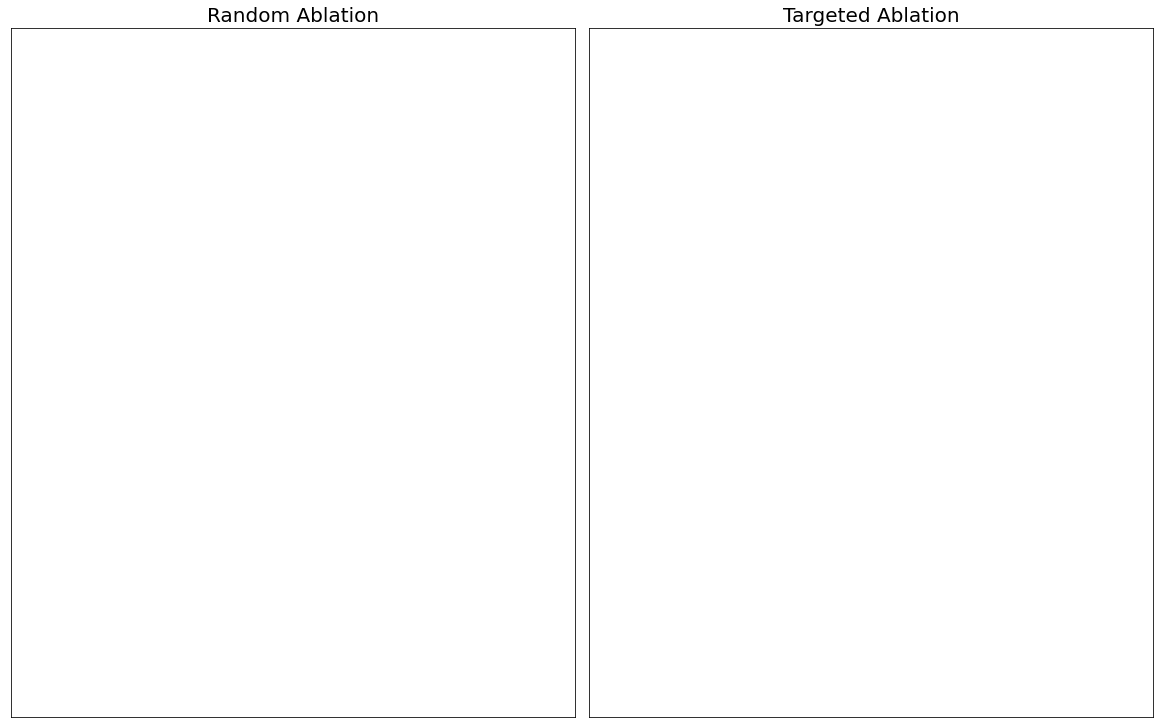

In [4]:
axis_fontsize = 15
title_fontsize = 20
legend_fontsize = 8
fig4 = plt.figure(figsize=(16,10), constrained_layout=True)
gs4 = fig4.add_gridspec(ncols=6, nrows=6)

# 3A CARTOON OF RANDOM ABLATION
f4_ax1 = fig4.add_subplot(gs4[0:6, 0:3])

# remove x and y ticks
# x axis
f4_ax1.set_xticklabels([])
f4_ax1.set_xticks([])

# y axis
f4_ax1.set_yticklabels([])
f4_ax1.set_yticks([])

f4_ax1.set_title("Random Ablation", fontsize=title_fontsize)

# 3B CARTOON OF TARGETED ABLATION
f4_ax2 = fig4.add_subplot(gs4[0:6, 3:])

# remove x and y ticks
# x axis
f4_ax2.set_xticklabels([])
f4_ax2.set_xticks([])

# y axis
f4_ax2.set_yticklabels([])
f4_ax2.set_yticks([])

f4_ax2.set_title("Targeted Ablation", fontsize=title_fontsize)